In [ ]:
# Import necessary libraries
import numpy as np
from scipy.spatial import distance
from itertools import combinations
from collections import defaultdict
import pandas as pd
from sklearn.datasets import load_iris


class CertifiableRobustness:
    def __init__(self, k, distance_function='euclidean'):
        self.k = k
        self.distance_function = distance_function

    def compute_distances(self, dataset, test_point):

        distances = [
            (distance.cdist([test_point], [row[:-1]], metric=self.distance_function)[0][0], idx)
            for idx, row in enumerate(dataset)
        ]
        return sorted(distances, key=lambda x: x[0])

    def classify(self, dataset, test_point):

        distances = self.compute_distances(dataset, test_point)
        k_neighbors = [dataset[distances[idx][1], -1] for idx in range(self.k)]
        return max(set(k_neighbors), key=k_neighbors.count)

    def certify_robustness(self, dataset, test_point, label):

        distances = self.compute_distances(dataset, test_point)
        for repair in self.generate_repairs(dataset):
            k_neighbors = [repair[distances[idx][1], -1] for idx in range(self.k)]
            other_labels = set(k_neighbors) - {label}

            if not other_labels:
                continue

            if k_neighbors.count(label) <= max(k_neighbors.count(l) for l in other_labels):
                return False
        return True


    def generate_repairs(self, dataset):

        repairs = [dataset]
        fd_blocks = self.identify_fd_blocks(dataset)

        for block in fd_blocks:
            new_repairs = []
            for repair in repairs:
                for subset in self.generate_subsets(block):
                    new_repair = self.apply_repair(repair, block, subset)
                    new_repairs.append(new_repair)
            repairs = new_repairs

        return repairs

    def identify_fd_blocks(self, dataset):

        fd_blocks = []
        grouped = defaultdict(list)

        for row in dataset:
            key = tuple(row[:-1])  # Using all features as a key example
            grouped[key].append(row)

        fd_blocks.extend(grouped.values())
        return fd_blocks

    def generate_subsets(self, block):

        subsets = []
        for i in range(1, len(block) + 1):
            subsets.extend(combinations(block, i))
        return subsets

    def apply_repair(self, dataset, block, subset):

        repaired_dataset = []
        subset_tuples = [tuple(row) for row in subset]  # Convert subset rows to tuples for comparison
        block_tuples = [tuple(row) for row in block]   # Convert block rows to tuples for comparison

        for row in dataset:
            row_tuple = tuple(row)
            if row_tuple in block_tuples and row_tuple not in subset_tuples:
                continue
            repaired_dataset.append(row)

        return np.array(repaired_dataset)



    def optimize_primary_key_case(self, dataset):

        primary_key_blocks = self.identify_fd_blocks(dataset)
        repairs = []

        for block in primary_key_blocks:
            block_tuples = [tuple(row) for row in block]
            for choice in block:
                choice_tuple = tuple(choice)
                repair = [
                    row for row in dataset
                    if tuple(row) not in block_tuples or tuple(row) == choice_tuple
                ]
                repairs.append(np.array(repair))

        return repairs


    def handle_uncertainty_models(self, dataset, model_type="?-sets", m=None):

        if model_type == "?-sets":
            if m is None:
                raise ValueError("For ?-sets, the parameter m must be specified.")

            repaired_datasets = []
            for to_remove in combinations(range(len(dataset)), m):
                repaired_dataset = np.delete(dataset, to_remove, axis=0)
                repaired_datasets.append(repaired_dataset)
            return repaired_datasets

        elif model_type == "or-sets":
            repaired_datasets = [dataset]
            for i in range(len(dataset)):
                for j in range(len(dataset[i]) - 1):
                    if isinstance(dataset[i][j], set):
                        new_repair = []
                        for value in dataset[i][j]:
                            new_row = dataset[i].copy()
                            new_row[j] = value
                            new_repair.append(new_row)
                        repaired_datasets.append(np.array(new_repair))
            return repaired_datasets

        elif model_type == "codd-tables":
            repaired_datasets = []
            for row in dataset:
                repaired_rows = []
                for i, value in enumerate(row[:-1]):
                    if value is None:
                        possible_values = [0, 1, 2]
                        for replacement in possible_values:
                            new_row = row.copy()
                            new_row[i] = replacement
                            repaired_rows.append(new_row)
                if repaired_rows:
                    repaired_datasets.append(np.array(repaired_rows))
                else:
                    repaired_datasets.append(np.array([row]))
            return repaired_datasets

        else:
            raise ValueError("Unsupported uncertainty model type.")

    def validate_hardness_cases(self, dataset, test_point, label):

        is_robust = self.certify_robustness(dataset, test_point, label)
        repair_count = self.count_repairs_predicting_label(dataset, test_point, label)

        if repair_count > 1000:
            return f"Hardness validated: {repair_count} repairs predict the label."
        else:
            return "Tractable case."

    def count_repairs_predicting_label(self, dataset, test_point, label):

        count = 0
        distances = self.compute_distances(dataset, test_point)
        for repair in self.generate_repairs(dataset):
            k_neighbors = [repair[distances[idx][1], -1] for idx in range(self.k)]
            other_labels = set(k_neighbors) - {label}

            if not other_labels:
                if k_neighbors.count(label) > 0:
                    count += 1
                continue

            if k_neighbors.count(label) > max(k_neighbors.count(l) for l in other_labels):
                count += 1
        return count


if __name__ == "__main__":
    # Synthetic dataset:
    dataset = np.array([
        [1, 0, 0],
        [1, 2, 0],
        [2, 0, 1],
        [2, 5, 1],
        [3, 1, 0],
        [4, 2, 2]
    ])

    test_point = np.array([0, 0])
    k = 3  # Number of neighbors

    # Initialize the certifier
    certifier = CertifiableRobustness(k)

    # Classify the test point
    predicted_label = certifier.classify(dataset, test_point)
    print(f"-----------Synthetic Dataset------------")
    print(f"Predicted Label: {predicted_label}")

    # Certify robustness
    is_robust = certifier.certify_robustness(dataset, test_point, predicted_label)
    print(f"Is Robust: {is_robust}")

    # Count repairs predicting the label
    count_repairs = certifier.count_repairs_predicting_label(dataset, test_point, predicted_label)
    print(f"Count of Repairs Predicting the Label: {count_repairs}")

    # Handle primary key optimization
    pk_repairs = certifier.optimize_primary_key_case(dataset)
    print(f"Primary Key Repairs: {len(pk_repairs)}")

    # Handle ?-sets
    qset_repairs = certifier.handle_uncertainty_models(dataset, model_type="?-sets", m=2)
    print(f"?-Set Repairs: {len(qset_repairs)}")

    # Validate hardness cases
    hardness_result = certifier.validate_hardness_cases(dataset, test_point, predicted_label)
    print(f"Hardness Validation: {hardness_result}")

    # ----------------------Real World Datasets: Iris Dataset and Adult Dataset----------------------------
    # Load the Iris dataset
    iris = load_iris()
    iris_data = np.column_stack((iris['data'], iris['target']))

    # Add some inconsistencies for testing
    inconsistent_iris_data = np.copy(iris_data)
    inconsistent_iris_data[::15, :-1] = np.nan  # Introduce missing values

    # Create a test point
    test_point = np.nanmean(inconsistent_iris_data[:, :-1], axis=0)  # Ignore NaNs for mean calculation

    # Initialize CertifiableRobustness
    k = 3
    certifier = CertifiableRobustness(k)

    # Test with Iris dataset
    predicted_label = certifier.classify(iris_data, test_point)
    print(f"-----------Real World Datasets------------")
    print(f"Predicted Label (Iris Dataset): {predicted_label}")

    is_robust = certifier.certify_robustness(iris_data, test_point, predicted_label)
    print(f"Is Robust (Iris Dataset): {is_robust}")

    count_repairs = certifier.count_repairs_predicting_label(iris_data, test_point, predicted_label)
    print(f"Count of Repairs Predicting the Label (Iris Dataset): {count_repairs}")

    # Load the Adult dataset
    url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
               "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
               "hours-per-week", "native-country", "income"]
    adult_data = pd.read_csv(url, header=None, names=columns, na_values=" ?")

    # Preprocess Adult dataset
    adult_data = adult_data.dropna()  # Drop rows with missing values
    adult_data_encoded = pd.get_dummies(adult_data, drop_first=True)  # One-hot encode categorical data
    adult_data_array = adult_data_encoded.to_numpy()

    # Take a subset of the dataset
    subset_size = 1000  # Adjust subset size as needed
    adult_data_subset = adult_data_array[:subset_size]

    # Ensure numeric data
    adult_data_subset = adult_data_subset.astype(float)

    # Create a test point for Adult dataset
    test_point_adult = adult_data_subset[0, :-1]  # Use the first record as a test point

    # Test with Adult dataset
    predicted_label_adult = certifier.classify(adult_data_subset, test_point_adult)
    print(f"Predicted Label (Adult Dataset): {predicted_label_adult}")

    is_robust_adult = certifier.certify_robustness(adult_data_subset, test_point_adult, predicted_label_adult)
    print(f"Is Robust (Adult Dataset): {is_robust_adult}")

    count_repairs_adult = certifier.count_repairs_predicting_label(adult_data_subset, test_point_adult, predicted_label_adult)
    print(f"Count of Repairs Predicting the Label (Adult Dataset): {count_repairs_adult}")



-----------Synthetic Dataset------------
Predicted Label: 0
Is Robust: True
Count of Repairs Predicting the Label: 1
Primary Key Repairs: 6
?-Set Repairs: 15
Hardness Validation: Tractable case.
-----------Real World Datasets------------
Predicted Label (Iris Dataset): 1.0
Is Robust (Iris Dataset): True
Count of Repairs Predicting the Label (Iris Dataset): 3
Predicted Label (Adult Dataset): 0.0
Is Robust (Adult Dataset): True
Count of Repairs Predicting the Label (Adult Dataset): 1


Figure 1: Repair counts for Iris Dataset test points


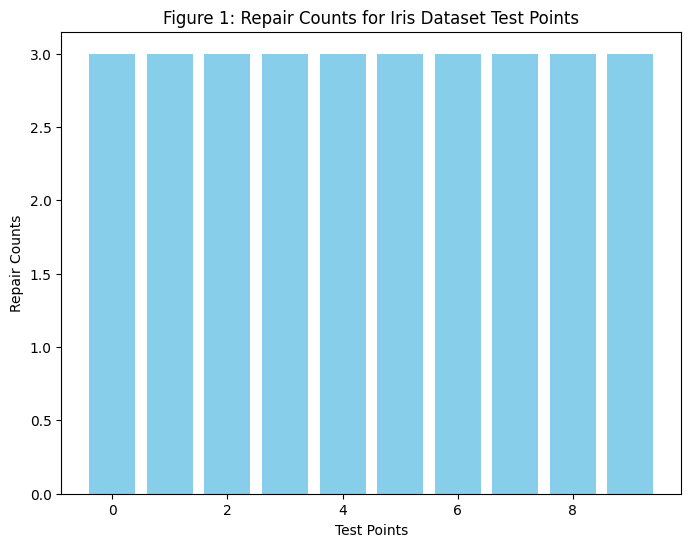

Figure 2: Runtime comparison between synthetic and real datasets


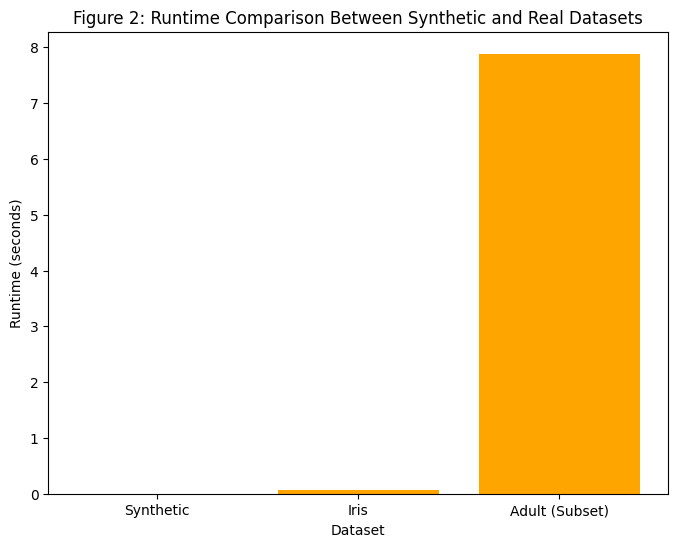

Figure 3: Accuracy consistency across all dataset repairs


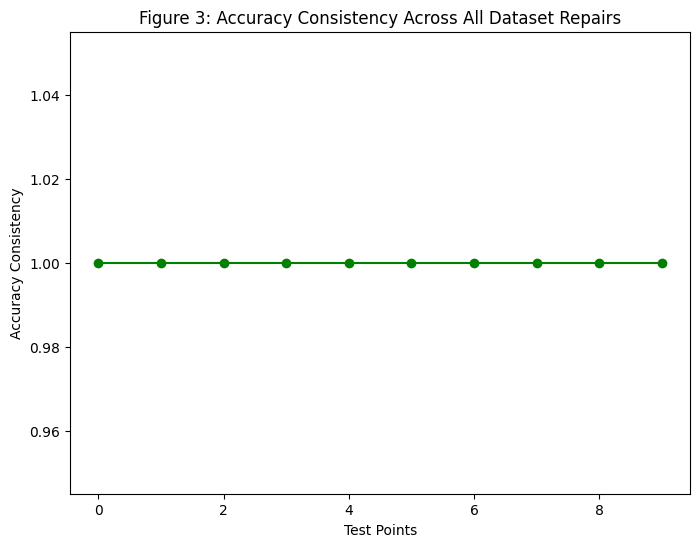

In [ ]:
import matplotlib.pyplot as plt
import time

# Generate Figure 1: Repair counts for Iris Dataset test points
def plot_repair_counts(iris_data, certifier):
    test_points = iris_data[:, :-1][:10]  # Use first 10 test points
    repair_counts = []
    for test_point in test_points:
        predicted_label = certifier.classify(iris_data, test_point)
        repair_count = certifier.count_repairs_predicting_label(iris_data, test_point, predicted_label)
        repair_counts.append(repair_count)

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(repair_counts)), repair_counts, color='skyblue')
    plt.xlabel("Test Points")
    plt.ylabel("Repair Counts")
    plt.title("Figure 1: Repair Counts for Iris Dataset Test Points")
    plt.show()

# Generate Figure 2: Runtime comparison between synthetic and real datasets
def plot_runtime_comparison(certifier, synthetic_dataset, iris_data, adult_data_subset):
    datasets = ["Synthetic", "Iris", "Adult (Subset)"]
    runtimes = []

    for dataset, label in zip([synthetic_dataset, iris_data, adult_data_subset], datasets):
        test_point = dataset[0, :-1]  # Use the first record as a test point
        start_time = time.time()
        predicted_label = certifier.classify(dataset, test_point)
        certifier.certify_robustness(dataset, test_point, predicted_label)
        end_time = time.time()
        runtimes.append(end_time - start_time)

    plt.figure(figsize=(8, 6))
    plt.bar(datasets, runtimes, color='orange')
    plt.xlabel("Dataset")
    plt.ylabel("Runtime (seconds)")
    plt.title("Figure 2: Runtime Comparison Between Synthetic and Real Datasets")
    plt.show()

# Generate Figure 3: Accuracy consistency across all dataset repairs
def plot_accuracy_consistency(iris_data, certifier):
    test_points = iris_data[:, :-1][:10]  # Use first 10 test points
    accuracies = []

    for test_point in test_points:
        predicted_label = certifier.classify(iris_data, test_point)
        repair_count = certifier.count_repairs_predicting_label(iris_data, test_point, predicted_label)
        total_repairs = len(certifier.generate_repairs(iris_data))
        accuracy = repair_count / total_repairs if total_repairs > 0 else 0
        accuracies.append(accuracy)

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(accuracies)), accuracies, marker='o', linestyle='-', color='green')
    plt.xlabel("Test Points")
    plt.ylabel("Accuracy Consistency")
    plt.title("Figure 3: Accuracy Consistency Across All Dataset Repairs")
    plt.show()

certifier = CertifiableRobustness(k=3)
synthetic_dataset = np.array([
    [1, 0, 0],
    [1, 2, 0],
    [2, 0, 1],
    [2, 5, 1],
    [3, 1, 0],
    [4, 2, 2]
])

# Call functions to generate figures
print("Figure 1: Repair counts for Iris Dataset test points")
plot_repair_counts(iris_data, certifier)

print("Figure 2: Runtime comparison between synthetic and real datasets")
plot_runtime_comparison(certifier, synthetic_dataset, iris_data, adult_data_subset)

print("Figure 3: Accuracy consistency across all dataset repairs")
plot_accuracy_consistency(iris_data, certifier)
